<a href="https://colab.research.google.com/github/nhathoangbui123/Plant-Disease-CNN/blob/main/Plant_Disease_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plant Disease Classification using CNN

In [1]:
# install library
!pip install -q tensorflow
!pip install -q split-folders

In [4]:
# download dataset from Kaggle
from google.colab import files
# print("Upload kaggle.json:")
# files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d vipoooool/new-plant-diseases-dataset
!unzip -q new-plant-diseases-dataset.zip -d new_plant_disease
print("Unzip done.")

Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
 98% 2.63G/2.70G [00:04<00:00, 332MB/s]
100% 2.70G/2.70G [00:05<00:00, 573MB/s]
Unzip done.


In [5]:
# prepare data
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (128, 128)
BATCH_SIZE = 32

base_dir = "new_plant_disease/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "valid")

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [6]:
# build CNN model
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(train_data.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_data,
    epochs=15,
    validation_data=val_data,
    callbacks=[reduce_lr, early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 310,726 (1.19 MB)

 Trainable params: 309,574 (1.18 MB)

 Non-trainable params: 1,152 (4.50 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 380s 168ms/step - accuracy: 0.4295 - loss: 2.0183 - val_accuracy: 0.6482 - val_loss: 1.2698 - learning_rate: 0.0010
Epoch 2/15
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 359s 163ms/step - accuracy: 0.7942 - loss: 0.6554 - val_accuracy: 0.8427 - val_loss: 0.5167 - learning_rate: 0.0010
Epoch 3/15
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 356s 162ms/step - accuracy: 0.8709 - loss: 0.4000 - val_accuracy: 0.8852 - val_loss: 0.3595 - learning_rate: 0.0010
Epoch 4/15
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 358s 163ms/step - accuracy: 0.9085 - loss: 0.2845 - val_accuracy: 0.8723 - val_loss: 0.4145 - learning_rate: 0.0010
Epoch 5/15
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 360s 164ms/step - accuracy: 0.9226 - loss: 0.2381 - val_accuracy: 0.9174 - val_loss: 0.2603 - learning_rate: 0.0010
Epoch 6/15
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 359s 163ms/step - accuracy: 0.9354 - loss: 0.2006 - val_accuracy: 0.7736 - val_loss: 0.8330 - learning_rate: 0.0010
Epoch 7/15
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 355s 162ms

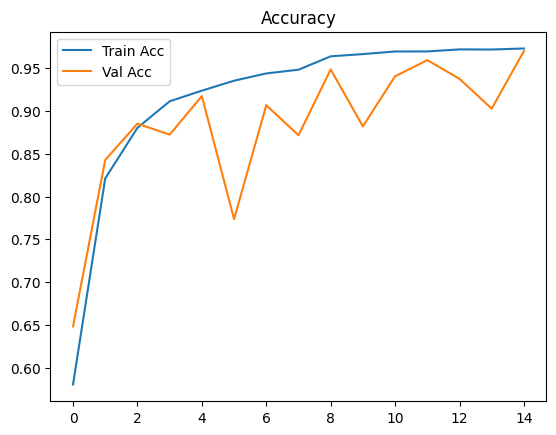

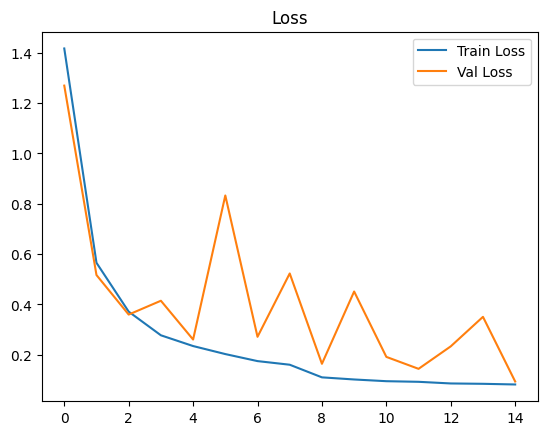

In [7]:
# Accuracy and Loss
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.show()

In [8]:
# Classification Report
from sklearn.metrics import classification_report
import numpy as np

val_preds = model.predict(val_data)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_data.classes

print(classification_report(y_true, y_pred, target_names=list(val_data.class_indices.keys())))

550/550 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.02      0.02      0.02       504
                                 Apple___Black_rot       0.03      0.03      0.03       497
                          Apple___Cedar_apple_rust       0.04      0.04      0.04       440
                                   Apple___healthy       0.03      0.03      0.03       502
                               Blueberry___healthy       0.01      0.01      0.01       454
          Cherry_(including_sour)___Powdery_mildew       0.01      0.01      0.01       421
                 Cherry_(including_sour)___healthy       0.04      0.04      0.04       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.03      0.03      0.03       410
                       Corn_(maize)___Common_rust_       0.03      0.03      0.03       477
               Corn_(maize)___Northe

Please upload new image for detect:


Saving 201909031808268962099.jpg to 201909031808268962099.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


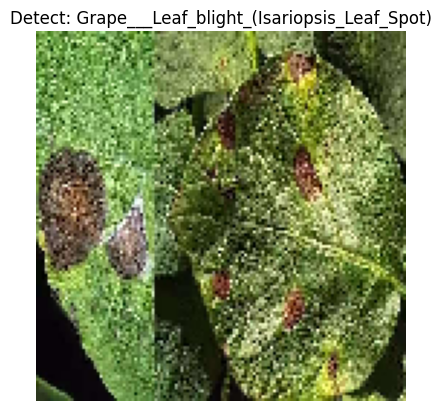

In [10]:
# Upload new image for detect
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def predict_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    class_names = list(train_data.class_indices.keys())

    plt.imshow(img)
    plt.title(f"Detect: {class_names[predicted_class]}")
    plt.axis('off')
    plt.show()

# Upload new image
from google.colab import files
print("Please upload new image for detect:")
uploaded = files.upload()
for img_path in uploaded.keys():
    predict_image(img_path)